# 882 Replication Paper: Flabbi 2010

- Read in data
- Define log-normal pdf & cdf 
- Estimate men and women separately to allow for parameters to very by gender

## Import Packages

In [132]:
# Data Manipulation 
import numpy as np
import pandas as pd

# General
import pdb

# Estimation
from scipy.optimize import minimize
import scipy.stats as stats

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline

## Import Data 

- CPS data on gender, wages, duration of unemployment
- M: males
- F: females
- U: unemployed
- E: employed 
- {M,F} X {E,U} = {males,females} X {employed, unemployed}

In [133]:
data=pd.read_csv('../data/est_c.csv')
data.columns = ['dur', 'wage', 'empl', 'women']

M = data[data['women']==0] #1186 men 
F = data[data['women']==1] #993 women 
U = data[data['empl']==0] #45 unemployed
E = data[data['empl']==1] #2134 employed

ME = M[M['empl']==1] #1109 employed men
MU = M[M['empl']==0] #18 unemployed men
FE = F[F['empl']==1] #966 employed women
FU = F[F['empl']==0] #27 unemployed women

### Summary Statistics, without trimming

In [134]:
agg_dict = {
    'wage': ['mean', 'std'],
    'dur': ['mean', 'std'],
}

In [135]:
print(data.groupby(['women', 'empl']).agg(agg_dict).to_latex()) # by gender

\begin{tabular}{llrrrr}
\toprule
  &   & \multicolumn{2}{l}{wage} & \multicolumn{2}{l}{dur} \\
  &   &       mean &       std &      mean &       std \\
women & empl &            &           &           &           \\
\midrule
0 & 0 &   0.000000 &  0.000000 &  4.923077 &  4.687447 \\
  & 1 &  21.258393 &  9.890162 &  0.000000 &  0.000000 \\
1 & 0 &   0.000000 &  0.000000 &  3.837607 &  3.341191 \\
  & 1 &  16.604563 &  8.307586 &  0.000000 &  0.000000 \\
\bottomrule
\end{tabular}



In [136]:
print(data.groupby(['empl']).agg(agg_dict).to_latex()) # all

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{wage} & \multicolumn{2}{l}{dur} \\
{} &       mean &       std &      mean &       std \\
empl &            &           &           &           \\
\midrule
0    &   0.000000 &  0.000000 &  4.271795 &  3.921109 \\
1    &  19.151739 &  9.492563 &  0.000000 &  0.000000 \\
\bottomrule
\end{tabular}



### Summary Statistics, with trimming

In [137]:
print(np.percentile(ME['wage'], 5))

7.2700000000000005


In [138]:
print(np.percentile(FE['wage'], 5))

5.75625


In [156]:
M_WAGE_COND = (data['wage'] > 7.27) #hard coded percentile so it does not continually update
M_COND = (data['women'] == 0)

F_WAGE_COND = (data['wage'] > 5.75625) #hard coded percentile so it does not continually update
F_COND = (data['women'] == 1)

DUR_COND = (data['dur'] > 0)

trim = data[ (M_COND & (M_WAGE_COND | DUR_COND)) | (F_COND & (F_WAGE_COND | DUR_COND)) ]

M = trim[trim['women']==0] #1071 men 
F = trim[trim['women']==1] #944 women 
U = trim[trim['empl']==0] #45 unemployed
E = trim[trim['empl']==1] #1970 employed

ME = M[M['empl']==1] #1053 employed men
MU = M[M['empl']==0] #18 unemployed men
FE = F[F['empl']==1] #917 employed women
FU = F[F['empl']==0] #27 unemployed women

In [157]:
trim.describe()

,dur,wage,empl,women
count,2071.000000,2071.000000,2071.000000,2071.000000
mean,0.092820,19.474685,0.978271,0.455818
std,0.845514,9.493358,0.145831,0.498164
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,12.700000,1.000000,0.000000
50%,0.000000,18.060000,1.000000,0.000000
75%,0.000000,24.486365,1.000000,1.000000
max,15.000000,65.000000,1.000000,1.000000


In [158]:
print(trim.groupby(['women', 'empl']).agg(agg_dict).to_latex()) # by gender

\begin{tabular}{llrrrr}
\toprule
  &   & \multicolumn{2}{l}{wage} & \multicolumn{2}{l}{dur} \\
  &   &       mean &       std &      mean &       std \\
women & empl &            &           &           &           \\
\midrule
0 & 0 &   0.000000 &  0.000000 &  4.923077 &  4.687447 \\
  & 1 &  22.093013 &  9.440473 &  0.000000 &  0.000000 \\
1 & 0 &   0.000000 &  0.000000 &  3.837607 &  3.341191 \\
  & 1 &  17.263817 &  8.002224 &  0.000000 &  0.000000 \\
\bottomrule
\end{tabular}



In [159]:
print(trim.groupby(['empl']).agg(agg_dict).to_latex()) # all

\begin{tabular}{lrrrr}
\toprule
{} & \multicolumn{2}{l}{wage} & \multicolumn{2}{l}{dur} \\
{} &       mean &       std &      mean &       std \\
empl &            &           &           &           \\
\midrule
0    &   0.000000 &  0.000000 &  4.271795 &  3.921109 \\
1    &  19.907242 &  9.138453 &  0.000000 &  0.000000 \\
\bottomrule
\end{tabular}



## Exploratory Data Analysis 
- Distribution of wages for men, women
- Distribution of durations for men, women
- Summary statistics of men v women

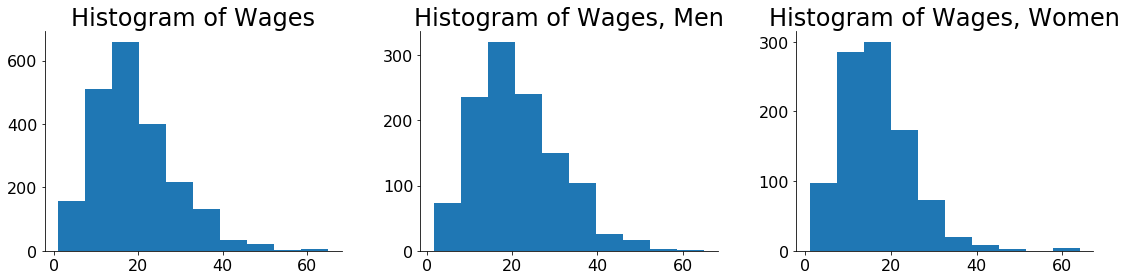

In [37]:
fig_wage = plt.figure(figsize=(16,4))

ax1 = fig_wage.add_subplot(131)
ax2 = fig_wage.add_subplot(132)
ax3 = fig_wage.add_subplot(133)

ax1.hist(E['he'])
ax2.hist(ME['he'])
ax3.hist(FE['he'])

ax1.set_title("Histogram of Wages")
ax2.set_title("Histogram of Wages, Men")
ax3.set_title("Histogram of Wages, Women")

plt.tight_layout()

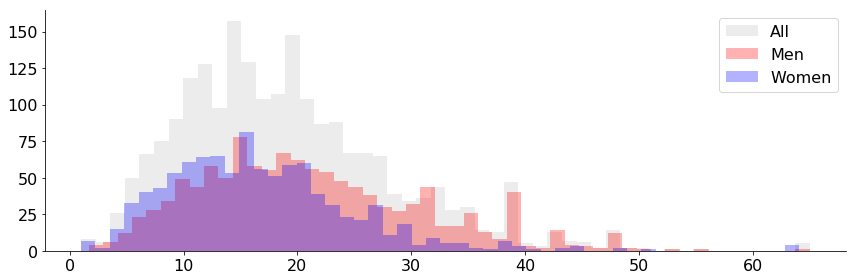

In [43]:
# Caleb
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.hist(E['he'], color='grey', alpha=.15, bins=50)
ax.hist(ME['he'], color='red', alpha=.3, bins=50)
ax.hist(FE['he'], color='blue', alpha=.3, bins=50)

ax.legend(['All', 'Men', 'Women'])

plt.tight_layout()

# fig, ax = plt.subplots(2, 1, figsize=(12, 4), sharex=True, sharey=True)

# # ax.hist(CPSdata['he'], color='grey', alpha=.15)
# ax[0].hist(CPSdataM['he'], color='red', alpha=.3, bins=50)
# ax[1].hist(CPSdataF['he'], color='blue', alpha=.3, bins=50)

# # ax.legend(['Men', 'Women'])

# plt.tight_layout()

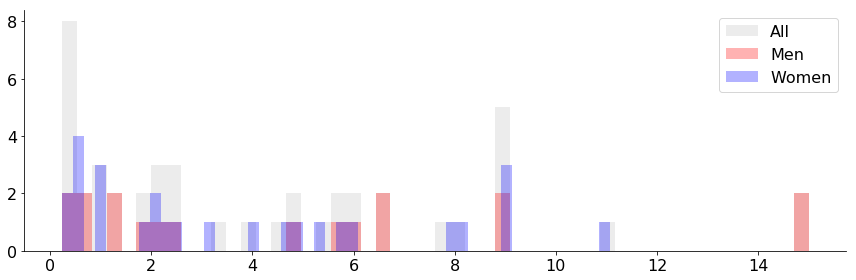

In [41]:
# fig_dur = plt.figure()

# ax1 = fig_dur.add_subplot(131)
# ax2 = fig_dur.add_subplot(132)
# ax3 = fig_dur.add_subplot(133)

# ax1.hist(U['ud'])
# ax2.hist(MU['ud'])
# ax3.hist(FU['ud'])

# ax1.set_title("Histogram of Unemployment Duration")
# ax2.set_title("Histogram of Unemployment Duration, Men")
# ax3.set_title("Histogram of Unemployment Duration, Women")

# plot.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.hist(U['ud'], color='grey', alpha=.15, bins=50)
ax.hist(MU['ud'], color='red', alpha=.3, bins=50)
ax.hist(FU['ud'], color='blue', alpha=.3, bins=50)

ax.legend(['All', 'Men', 'Women'])

plt.tight_layout()

## Estimation 

- Reservation wage = min(accepted wage), by gender
- MLE using log normal distribution

- Estimations 1-3: Same arrival and termination rates
- Estimations 4-6: Gender specific arrival and termination rates

In [160]:
# Initial Conditions

wstarM = min(ME['wage'])
wstarF = min(FE['wage'])

λ_M = 0.22
λ_F = 0.22
η_M = 0.005
η_F = 0.005
# α = 0.5  #FIXED
μ_M = 3.456
μ_F= 3.454
σ_M = 0.558
σ_F = 0.423
p = 0.5
d_F = 10
# d_M = 0   #FIXED

init = [λ_M, λ_F, η_M, η_F, μ_M, σ_M, μ_F, σ_F, p, d_F]

### Wage Function

In [ ]:
def f_w(wage: np.array, α: float, wstar: float):
    """
    Wage functions
    """
    return (wage - (1-α)*wstar)*(1/α)

### Estimation 1: Same arrival and termination, Productivity Differences, No Prejudice

In [ ]:
def loglik1(params: list):
    """
    Calculates the log likelihood with the log normal distribution
    """
    
    λ_M = np.exp(params[0])
    λ_F = np.exp(params[0])
    η_M = np.exp(params[2])
    η_F = np.exp(params[2])
    μ_M = params[4]
    σ_M = np.exp(params[5])
    μ_F = params[6]
    σ_F = np.exp(params[7])
    d_F = 0
    p = 0
    α = 0.5
    
#    pdb.set_trace()
    
    hM = λ_M * ( (1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L00 = (η_M/(η_M+hM)) * hM * np.exp(-hM*np.sum(MU.values[:,0])); #unemployed men

    L01a = ( ( (1/α)*stats.lognorm.pdf(f_w(ME.values[:,1],α,wstarM),μ_M,σ_M) )/(1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L01 = np.log(hM/(η_M+hM)) + np.sum( np.log(1 + L01a) ); #employed men
    
    hF = λ_F*( (1-p)*(1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) + p*(1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L10 = ( (η_F/(η_F+hF)) * hF * np.exp(-hF*np.sum(FU.values[:,0])) ); #unemployed women

    L11a = ( ( ((1-p)/α)*stats.lognorm.pdf(f_w(FE.values[:,1],α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) );
    L11b = ( ( (p/α)*stats.lognorm.pdf(f_w((FE.values[:,1]+α*d_F),α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L11 = np.log(hF/(η_F+hF)) + np.sum( np.log(1 + L11a + L11b) ); #employed women

    results = np.log(1+L00) + L01 + np.log(1+L10) + L11

    return -1*results

In [ ]:
est1 = minimize(loglik1, init, method='nelder-mead', options={'maxiter': 10000})

### Estimation 2: Same arrival and termination, Prejudice, No Productivity Differences

In [ ]:
def loglik2(params: list):
    """
    Calculates the log likelihood with the log normal distribution
    """
    
    λ_M = np.exp(params[0])
    λ_F = np.exp(params[0])
    η_M = np.exp(params[2])
    η_F = np.exp(params[2])
    μ_M = params[4]
    σ_M = np.exp(params[5])
    μ_F = params[4]
    σ_F = np.exp(params[5])
    d_F = np.exp(params[9])
    p = (np.exp(params[8]))/(1+np.exp(params[8]))
    α = 0.5
    
#    pdb.set_trace()
    
    hM = λ_M * ( (1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L00 = (η_M/(η_M+hM)) * hM * np.exp(-hM*np.sum(MU.values[:,0])); #unemployed men

    L01a = ( ( (1/α)*stats.lognorm.pdf(f_w(ME.values[:,1],α,wstarM),μ_M,σ_M) )/(1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L01 = np.log(hM/(η_M+hM)) + np.sum( np.log(1 + L01a) ); #employed men
    
    hF = λ_F*( (1-p)*(1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) + p*(1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L10 = ( (η_F/(η_F+hF)) * hF * np.exp(-hF*np.sum(FU.values[:,0])) ); #unemployed women

    L11a = ( ( ((1-p)/α)*stats.lognorm.pdf(f_w(FE.values[:,1],α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) );
    L11b = ( ( (p/α)*stats.lognorm.pdf(f_w((FE.values[:,1]+α*d_F),α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L11 = np.log(hF/(η_F+hF)) + np.sum( np.log(1 + L11a + L11b) ); #employed women

    results = np.log(1+L00) + L01 + np.log(1+L10) + L11

    return -1*results

In [ ]:
est2 = minimize(loglik2, init, method='nelder-mead', options={'maxiter': 10000})

### Estimation 4: Productivity Differences, No Prejudice

In [ ]:
def loglik4(params: list):
    """
    Calculates the log likelihood with the log normal distribution
    """
    
    λ_M = np.exp(params[0])
    λ_F = np.exp(params[1])
    η_M = np.exp(params[2])
    η_F = np.exp(params[3])
    μ_M = params[4]
    σ_M = np.exp(params[5])
    μ_F = params[6]
    σ_F = np.exp(params[7])
    d_F = 0
    p = 0
    α = 0.5
    
#    pdb.set_trace()
    
    hM = λ_M * ( (1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L00 = (η_M/(η_M+hM)) * hM * np.exp(-hM*np.sum(MU.values[:,0])); #unemployed men

    L01a = ( ( (1/α)*stats.lognorm.pdf(f_w(ME.values[:,1],α,wstarM),μ_M,σ_M) )/(1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L01 = np.log(hM/(η_M+hM)) + np.sum( np.log(1 + L01a) ); #employed men
    
    hF = λ_F*( (1-p)*(1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) + p*(1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L10 = ( (η_F/(η_F+hF)) * hF * np.exp(-hF*np.sum(FU.values[:,0])) ); #unemployed women

    L11a = ( ( ((1-p)/α)*stats.lognorm.pdf(f_w(FE.values[:,1],α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) );
    L11b = ( ( (p/α)*stats.lognorm.pdf(f_w((FE.values[:,1]+α*d_F),α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L11 = np.log(hF/(η_F+hF)) + np.sum( np.log(1 + L11a + L11b) ); #employed women

    results = np.log(1+L00) + L01 + np.log(1+L10) + L11

    return -1*results

In [ ]:
est4 = minimize(loglik4, init, method='nelder-mead', options={'maxiter': 10000})

### Estimation 5: Prejudice, No Productivity Differences

In [ ]:
def loglik5(params: list):
    """
    Calculates the log likelihood with the log normal distribution
    """
    
    λ_M = np.exp(params[0])
    λ_F = np.exp(params[1])
    η_M = np.exp(params[2])
    η_F = np.exp(params[3])
    μ_M = params[4]
    σ_M = np.exp(params[5])
    μ_F = params[4]
    σ_F = np.exp(params[5])
    d_F = np.exp(params[9])
    p = (np.exp(params[8]))/(1+np.exp(params[8]))
    α = 0.5
    
#    pdb.set_trace()
    
    hM = λ_M * ( (1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L00 = (η_M/(η_M+hM)) * hM * np.exp(-hM*np.sum(MU.values[:,0])); #unemployed men

    L01a = ( ( (1/α)*stats.lognorm.pdf(f_w(ME.values[:,1],α,wstarM),μ_M,σ_M) )/(1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L01 = np.log(hM/(η_M+hM)) + np.sum( np.log(1 + L01a) ); #employed men
    
    hF = λ_F*( (1-p)*(1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) + p*(1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L10 = ( (η_F/(η_F+hF)) * hF * np.exp(-hF*np.sum(FU.values[:,0])) ); #unemployed women

    L11a = ( ( ((1-p)/α)*stats.lognorm.pdf(f_w(FE.values[:,1],α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) );
    L11b = ( ( (p/α)*stats.lognorm.pdf(f_w((FE.values[:,1]+α*d_F),α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L11 = np.log(hF/(η_F+hF)) + np.sum( np.log(1 + L11a + L11b) ); #employed women

    results = np.log(1+L00) + L01 + np.log(1+L10) + L11

    return -1*results

In [ ]:
est5 = minimize(loglik5, init, method='nelder-mead', options={'maxiter': 10000})

### Estimation 6: Productivity Differences and Prejudice

In [164]:
def loglik6(params: list):
    """
    Calculates the log likelihood with the log normal distribution
    """
    
    λ_M = np.exp(params[0])
    λ_F = np.exp(params[1])
    η_M = np.exp(params[2])
    η_F = np.exp(params[3])
    μ_M = params[4]
    σ_M = np.exp(params[5])
    μ_F = params[6]
    σ_F = np.exp(params[7])
    d_F = np.exp(params[9])
    p = (np.exp(params[8]))/(1+np.exp(params[8]))
    α = 0.5
    
#    pdb.set_trace()
    
    hM = λ_M * ( (1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L00 = (η_M/(η_M+hM)) * hM * np.exp(-hM*np.sum(MU.values[:,0])); #unemployed men

    L01a = ( ( (1/α)*stats.lognorm.pdf(f_w(ME.values[:,1],α,wstarM),μ_M,σ_M) )/(1-stats.lognorm.cdf(wstarM,μ_M,σ_M)) );
    L01 = np.log(hM/(η_M+hM)) + np.sum( np.log(1 + L01a) ); #employed men
    
    hF = λ_F*( (1-p)*(1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) + p*(1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L10 = ( (η_F/(η_F+hF)) * hF * np.exp(-hF*np.sum(FU.values[:,0])) ); #unemployed women

    L11a = ( ( ((1-p)/α)*stats.lognorm.pdf(f_w(FE.values[:,1],α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf(wstarF,μ_F,σ_F)) );
    L11b = ( ( (p/α)*stats.lognorm.pdf(f_w((FE.values[:,1]+α*d_F),α,wstarF),μ_F,σ_F) ) / (1-stats.lognorm.cdf((wstarF+d_F),μ_F,σ_F)) );
    L11 = np.log(hF/(η_F+hF)) + np.sum( np.log(1 + L11a + L11b) ); #employed women

    results = np.log(1+L00) + L01 + np.log(1+L10) + L11

    return -1*results

In [165]:
est6 = minimize(loglik6, init, method='nelder-mead', options={'maxiter': 10000})

/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/Users/megan.mccoy/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):
